In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import experiments.toy_regression as exp
import matplotlib.pyplot as plt
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training.util import plot_losses, GaussWrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
device = torch.device("cpu")

In [17]:
batch_size = 50
noise = torch.tensor(0.02).to(device) # 3, 0.02
def make_layers(in_size):
    return [
        ("fc", (in_size, 50)),
        ("relu", ()),
        ("fc", (50, 1))
    ]
learn_var = True
def sgd(lr):
    return lambda parameters: torch.optim.SGD(parameters, lr)

In [18]:
from experiments.uci import UCIDatasets
torch.manual_seed(42)
uci = UCIDatasets("housing", "./data/")
trainloader = torch.utils.data.DataLoader(uci.get_split(train=True), batch_size)
testloader = torch.utils.data.DataLoader(uci.get_split(train=False), batch_size)

In [85]:
torch.manual_seed(42)
from training.pp import PointPredictor
pp = GaussWrapper(PointPredictor(make_layers(13)), torch.tensor(0.1), True)
pp.train(50, sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=100)
pp_res = RegressionResults(testloader, "Point Predictor", pp.infer, 1, device, fit_gaussian=False)
pp_res.lml

Generated model: Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)
751 trainable parameters
Epoch 0: loss 0.03329019993543625
Final loss -0.012070344761013985


tensor(-15.7197)

In [31]:
from training.swag import SwagModel
torch.manual_seed(42)

swag_config = {
    "start_epoch": 1500,
    "update_every_batches": len(trainloader) * 4,
    "deviation_samples": 50
}
swag = SwagModel(make_layers(13), swag_config)
swag.train(2000, torch.nn.MSELoss(), sgd(lr=0.01), trainloader, batch_size, device, report_every_epochs=100)
swag_res = RegressionResults(testloader, "SWAG", swag.infer, 100, torch.tensor(0.1), device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)
751 trainable parameters
Epoch 0: loss 0.017887109890580177
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss 0.002534032566472888
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 200: loss 0.0020374346058815718
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 300: loss 0.0017599101411178708
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 400: loss 0.001588271465152502
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 500: loss 0.0014602004084736109
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 600: loss 0.0013578454963862896
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 700: loss 0.0012575850123539567
SWAG: Collected 0 out of 5

In [32]:
from training.ensemble import Ensemble

torch.manual_seed(42)
ensemble = Ensemble([PointPredictor(make_layers(13)) for _ in range(5)])
ensemble.train(2000, torch.nn.MSELoss(), sgd(0.01), trainloader, batch_size, device, report_every_epochs=100)
ensemble_res = RegressionResults(testloader, "Ensemble-5", ensemble.infer, 1, torch.tensor(0.1), device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)
751 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)
751 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)
751 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)
751 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)
751 trainable parameters
Training ensemble member 0
Epoch 0: loss 0.017887109890580177
Epoch 100: lo

In [33]:
from training.dropout import MonteCarloDropoutModule

torch.manual_seed(42)
mc_dropout = MonteCarloDropoutModule(make_layers(13), 0.1)
mc_dropout.train(2000, torch.nn.MSELoss(), sgd(0.01), trainloader, batch_size, device, report_every_epochs=100)
mc_res = RegressionResults(testloader, "Monte Carlo Dropout", mc_dropout.infer, 100, torch.tensor(0.1), device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): FixableDropout()
  (2): ReLU()
  (3): Linear(in_features=50, out_features=1, bias=True)
)
751 trainable parameters
Epoch 0: loss 0.018756167963147163
Epoch 100: loss 0.003283438039943576
Epoch 200: loss 0.0026815468445420265
Epoch 300: loss 0.0026668671052902937
Epoch 400: loss 0.0021280739456415176
Epoch 500: loss 0.0024106097407639027
Epoch 600: loss 0.0020720032043755054
Epoch 700: loss 0.001980462344363332
Epoch 800: loss 0.0016951423604041338
Epoch 900: loss 0.0015707951970398426
Epoch 1000: loss 0.0016615291824564338
Epoch 1100: loss 0.0016819329466670752
Epoch 1200: loss 0.0015443313168361783
Epoch 1300: loss 0.0015647010877728462
Epoch 1400: loss 0.0014606346376240253
Epoch 1500: loss 0.0014742615167051554
Epoch 1600: loss 0.001516866497695446
Epoch 1700: loss 0.0014708606759086251
Epoch 1800: loss 0.0015078186988830566
Epoch 1900: loss 0.0013051560381427407
Final loss 0.00156789843458

In [34]:
from training.bbb import GaussianPrior, BBBModel

torch.manual_seed(42)
bbb_prior = GaussianPrior(0, 1)
bbb = BBBModel(bbb_prior, "activations", make_layers(13))
bbb.train(2000, torch.nn.MSELoss(reduction="sum"), sgd(lr=0.01), trainloader, batch_size, device, report_every_epochs=100, kl_rescaling=5)
bbb_res = RegressionResults(testloader, "Bayes By Backprop", bbb.infer, 100, torch.tensor(0.1), device, fit_gaussian=False)

Generated model: Sequential(
  (0): BBBLinear()
  (1): ReLU()
  (2): BBBLinear()
)
1502 trainable parameters
Epoch 0: loss 19.56146812438965
Epoch 100: loss 8.292510986328125
Epoch 200: loss 4.662649631500244
Epoch 300: loss 3.523364305496216
Epoch 400: loss 2.9862961769104004
Epoch 500: loss 2.7562448978424072
Epoch 600: loss 2.5873587131500244
Epoch 700: loss 2.6038434505462646
Epoch 800: loss 2.5029029846191406
Epoch 900: loss 2.5141870975494385
Epoch 1000: loss 2.502917766571045
Epoch 1100: loss 2.446200370788574
Epoch 1200: loss 2.535146474838257
Epoch 1300: loss 2.424084186553955
Epoch 1400: loss 2.43912410736084
Epoch 1500: loss 2.489593505859375
Epoch 1600: loss 2.424009323120117
Epoch 1700: loss 2.4520263671875
Epoch 1800: loss 2.5035712718963623
Epoch 1900: loss 2.5259079933166504
Final loss 2.4465172290802


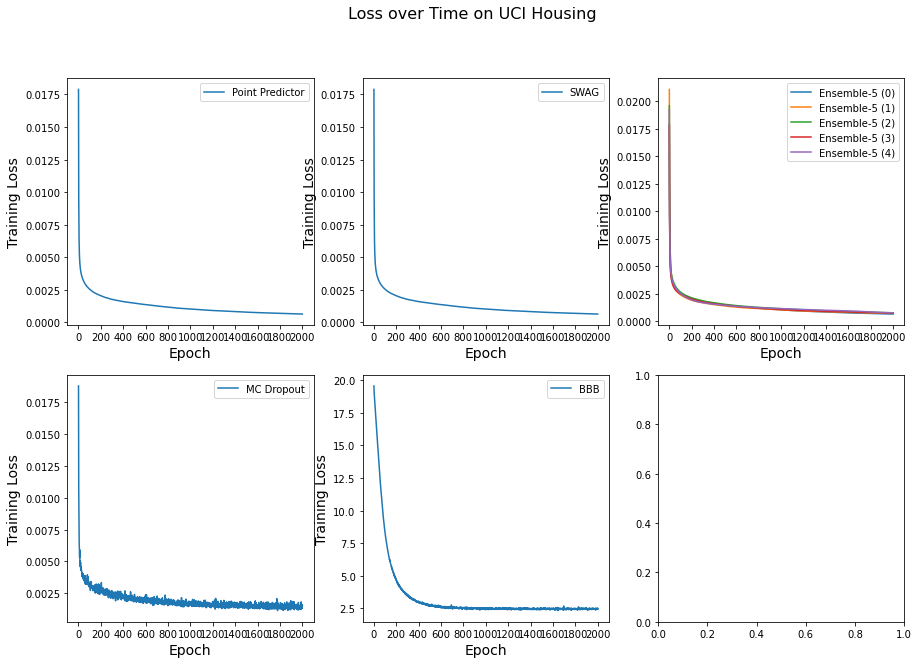

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Loss over Time on UCI Housing", fontsize=16)
plot_losses("Point Predictor", pp.all_losses(), axes[0,0])
plot_losses("SWAG", swag.all_losses(), axes[0,1])
plot_losses("Ensemble-5", ensemble.all_losses(), axes[0,2])
plot_losses("MC Dropout", mc_dropout.all_losses(), axes[1,0])
plot_losses("BBB", bbb.all_losses(), axes[1,1])

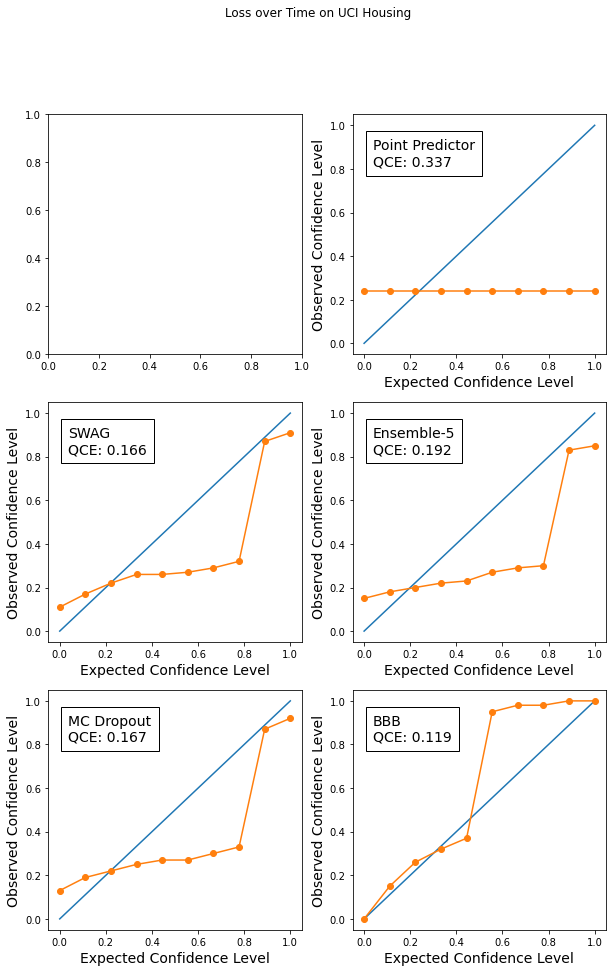

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
fig.suptitle("Loss over Time on UCI Housing")
plot_calibration("Point Predictor", pp_res, axes[0,1])
plot_calibration("SWAG", swag_res, axes[1,0])
plot_calibration("Ensemble-5", ensemble_res, axes[1,1])
plot_calibration("MC Dropout", mc_res, axes[2,0])
plot_calibration("BBB", bbb_res, axes[2,1])

In [53]:
plot_table("Boston Housing", [pp_res, swag_res, ensemble_res, mc_res, bbb_res])

NameError: name 'swag_res' is not defined